In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
%matplotlib inline
import backtrader as bt
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


ETF로 매수하는 것이 간편하니 적절한 ETF 데이터를 다운받습니다. 미국 전체 주식 ETF인 VTI, 선진국 주식 ETF인 EFA, 미국 물가연동채 ETF TIP, 미국 채권 ETF인 AGG를 사용합니다.

In [2]:
start = '2004-01-05'
end = '2021-03-19'
vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti_Close")
efa = web.DataReader("EFA", 'yahoo', start, end)['Adj Close'].to_frame("efa_Close")
tip = web.DataReader("TIP", 'yahoo', start, end)['Adj Close'].to_frame("tip_Close")
agg = web.DataReader("AGG", 'yahoo', start, end)['Adj Close'].to_frame("agg_Close")

In [3]:
vti.head()

,vti_Close
Date,
2004-01-05,38.877769
2004-01-06,39.011299
2004-01-07,39.123177
2004-01-08,39.267567
2004-01-09,39.014927


일단 모델 포트폴리오로, 매일 50:30:10:10 비중을 맞추는 것으로 생각하고 만듭니다. 거래비용은 생략합니다.

In [4]:
vti_return = vti.pct_change(periods=1)
efa_return = efa.pct_change(periods=1)
tip_return = tip.pct_change(periods=1)
agg_return = agg.pct_change(periods=1)
df_return = pd.concat([vti_return, efa_return, tip_return, agg_return], axis=1)

df_return.head()

,vti_Close,efa_Close,tip_Close,agg_Close
Date,,,,
2004-01-05,NaN,NaN,NaN,NaN
2004-01-06,0.003435,0.001502,0.006413,0.004523
2004-01-07,0.002868,-0.010000,0.000785,0.002251
2004-01-08,0.003691,0.014358,-0.003821,-0.000292
2004-01-09,-0.006434,-0.006330,0.007572,0.008305


In [5]:
df_return['FourFund_return'] = df_return['vti_Close']*0.5 + df_return['efa_Close']*0.3 + df_return['tip_Close']*0.1 + df_return['agg_Close']*0.1
df_return.head()

,vti_Close,efa_Close,tip_Close,agg_Close,FourFund_return
Date,,,,,
2004-01-05,NaN,NaN,NaN,NaN,NaN
2004-01-06,0.003435,0.001502,0.006413,0.004523,0.003262
2004-01-07,0.002868,-0.010000,0.000785,0.002251,-0.001262
2004-01-08,0.003691,0.014358,-0.003821,-0.000292,0.005741
2004-01-09,-0.006434,-0.006330,0.007572,0.008305,-0.003528


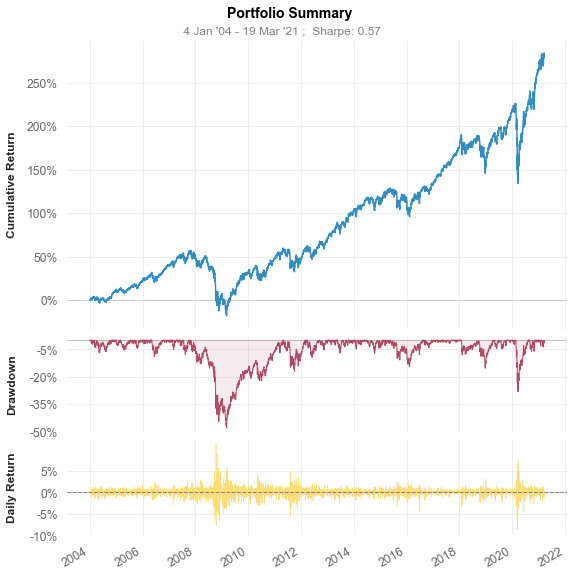

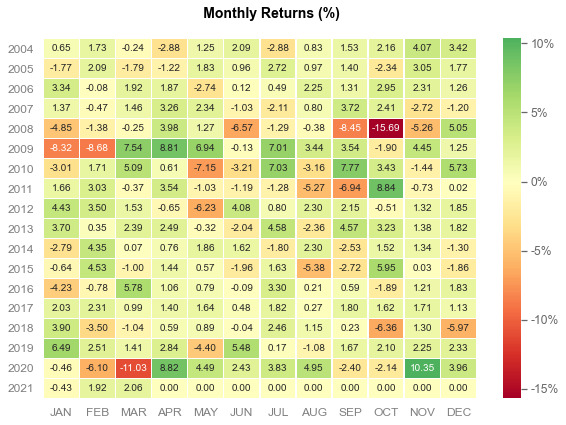

In [6]:
quantstats.reports.plots(df_return['FourFund_return'], mode='basic')

매일 비중을 맞춘 결과 연 복리 수익률 8.06%, 샤프 비율 0.57, MDD -48% 정도입니다. MDD가 너무 높아 그리 좋은 전략은 아닙니다.

In [7]:
quantstats.reports.metrics(df_return['FourFund_return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-01-05
End Period                 2021-03-19
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          279.83%
CAGR%                      8.06%
Sharpe                     0.57
Sortino                    0.8
Max Drawdown               -47.85%
Longest DD Days            1272
Volatility (ann.)          15.74%
Calmar                     0.17
Skew                       -0.17
Kurtosis                   15.31

Expected Daily %           0.03%
Expected Monthly %         0.65%
Expected Yearly %          7.7%
Kelly Criterion            5.98%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.6%
Expected Shortfall (cVaR)  -1.6%

Payoff Ratio               0.89
Profit Factor              1.12
Common Sense Ratio         1.05
CPC Index                  0.56
Tail Ratio                 0.94
Outlier Win Ratio          4.42
Outlier Loss Ratio         4.4

위에서 한 것처럼 그냥 만들어도 되지만, 백테스트에 많이 쓰이는 Backtrader 패키지를 한번 사용해 보겠습니다. Input 형식을 맞추어야 합니다.

In [8]:
vti = vti.rename({'vti_Close':'Close'}, axis='columns')
efa = efa.rename({'efa_Close':'Close'}, axis='columns')
tip = tip.rename({'tip_Close':'Close'}, axis='columns')
agg = agg.rename({'agg_Close':'Close'}, axis='columns')

for column in ['Open', 'High', "Low"]:
    vti[column] = vti["Close"]
    efa[column] = efa["Close"]
    tip[column] = tip["Close"]
    agg[column] = agg["Close"]

In [9]:
vti.head()

,Close,Open,High,Low
Date,,,,
2004-01-05,38.877769,38.877769,38.877769,38.877769
2004-01-06,39.011299,39.011299,39.011299,39.011299
2004-01-07,39.123177,39.123177,39.123177,39.123177
2004-01-08,39.267567,39.267567,39.267567,39.267567
2004-01-09,39.014927,39.014927,39.014927,39.014927


50:30:10:10 비율로 매수하고 20 거래일마다 리밸런싱하는 전략입니다.

In [10]:
class AssetAllocation_FourFund(bt.Strategy):
    params = (
        ('USequity',0.5),
        ('DEVequity', 0.3),
        ('USTIPS', 0.1),
        ('USBond', 0.1),
    )
    def __init__(self):
        self.VTI = self.datas[0]
        self.EFA = self.datas[1]
        self.TIP = self.datas[2]
        self.AGG = self.datas[3]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTI, target=self.params.USequity)
            self.order_target_percent(self.EFA, target=self.params.DEVequity)
            self.order_target_percent(self.TIP, target=self.params.USTIPS)
            self.order_target_percent(self.AGG, target=self.params.USBond)
        self.counter += 1

In [11]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTI = bt.feeds.PandasData(dataname = vti)
EFA = bt.feeds.PandasData(dataname = efa)
TIP = bt.feeds.PandasData(dataname = tip)
AGG = bt.feeds.PandasData(dataname = agg)

cerebro.adddata(VTI)
cerebro.adddata(EFA)
cerebro.adddata(TIP)
cerebro.adddata(AGG)

cerebro.addstrategy(AssetAllocation_FourFund)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

#quantstats.reports.html(returns, output = 'Report_AssetAllocation_6040.html', title='AssetAllocation_6040')

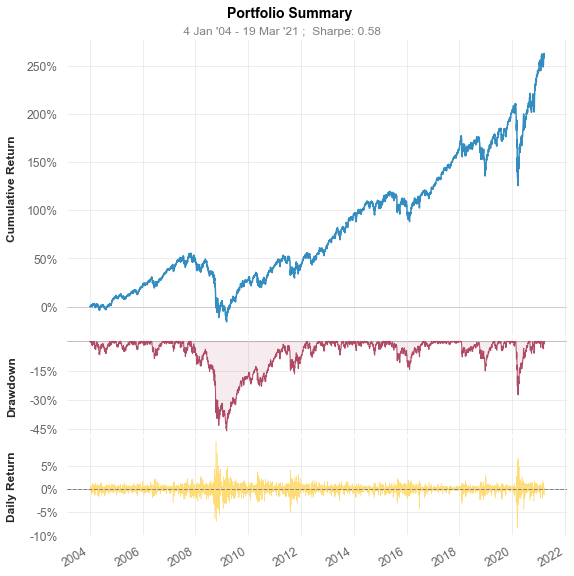

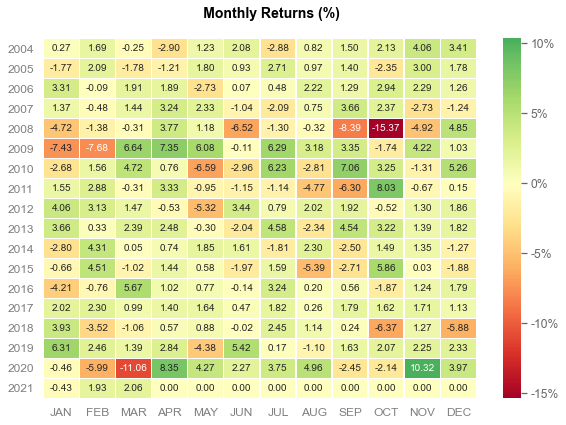

In [12]:
quantstats.reports.plots(returns, mode='basic')

20 거래일마다 리밸런싱하는 것으로 바꾸니 연 복리 수익률 7.7%, 샤프 비율 0.58, MDD -46% 정도로 나옵니다.

In [13]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-01-05
End Period                 2021-03-19
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          258.75%
CAGR%                      7.7%
Sharpe                     0.58
Sortino                    0.8
Max Drawdown               -45.87%
Longest DD Days            1607
Volatility (ann.)          14.68%
Calmar                     0.17
Skew                       -0.32
Kurtosis                   13.89

Expected Daily %           0.03%
Expected Monthly %         0.62%
Expected Yearly %          7.35%
Kelly Criterion            5.93%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.49%
Expected Shortfall (cVaR)  -1.49%

Payoff Ratio               0.89
Profit Factor              1.12
Common Sense Ratio         1.04
CPC Index                  0.56
Tail Ratio                 0.93
Outlier Win Ratio          4.17
Outlier Loss Ratio         4

월간 데이터를 사용하면 훨씬 더 과거의 결과도 테스트해 볼 수 있습니다. 가장 긴 시계열의 경우 1900년 1월부터 2020년 12월까지의 데이터가 있습니다.

In [14]:
MonthlyReturn = pd.read_excel('MonthlyAssetClassReturn.xlsx')

In [15]:
MonthlyReturn.head()

,Data Index,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
0,1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


시계열로 바꾸어 주는 것이 사용하기 편합니다. 1열인 Data Index가 월말 날짜이므로, 이 열을 인덱스로 잡습니다.

In [16]:
MonthlyReturn = MonthlyReturn.set_index('Data Index')

In [17]:
MonthlyReturn.head()

,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,GSCI,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
Data Index,,,,,,,,,,,,,,,,,,,,,
1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


필요한 것만 뽑아옵니다. 미국 전체 채권 데이터가 없으니 10년 만기 국채로 대체합니다. 월간 미국 주식(S&P 500), 월간 선진국 주식, 월간 TIPS, 월간 10년 만기 미국 국채 데이터입니다. 1973년 2월부터 2020년 12월까지 약 48년치 테스트입니다.

In [18]:
Monthly_FourFund = MonthlyReturn.loc[MonthlyReturn.index >= '1973-02-28', ['S&P 500 Total return', 'MSCI EAFE', 'US 10 YR', 'TIPS Series']]
Monthly_FourFund.head()

,S&P 500 Total return,MSCI EAFE,US 10 YR,TIPS Series
Data Index,,,,
1973-02-28,-0.035212,0.082721,-0.001738,0.002414
1973-03-31,0.000931,0.006339,-0.000927,-0.003227
1973-04-30,-0.038394,-0.055983,0.007770,0.009247
1973-05-31,-0.016374,0.024366,-0.010804,-0.003327
1973-06-30,-0.004016,0.024791,0.005058,0.004130


In [20]:
Monthly_FourFund['Monthly_FourFund'] = Monthly_FourFund['S&P 500 Total return'] * 0.5 + Monthly_FourFund['MSCI EAFE'] * 0.3 + Monthly_FourFund['US 10 YR'] * 0.1 + Monthly_FourFund['TIPS Series'] * 0.1
Monthly_FourFund.head()

,S&P 500 Total return,MSCI EAFE,US 10 YR,TIPS Series,Monthly_FourFund
Data Index,,,,,
1973-02-28,-0.035212,0.082721,-0.001738,0.002414,0.007278
1973-03-31,0.000931,0.006339,-0.000927,-0.003227,0.001952
1973-04-30,-0.038394,-0.055983,0.007770,0.009247,-0.034290
1973-05-31,-0.016374,0.024366,-0.010804,-0.003327,-0.002290
1973-06-30,-0.004016,0.024791,0.005058,0.004130,0.006348


월간 데이터이므로, 일간 데이터 기준인 패키지가 주는 값을 적절히 조정해야 합니다. 1년 12개월 252거래일을 가정합니다. 1973년 2월부터 약 48년 동안 샤프 비율은 0.85로 나옵니다. 아래 그림의 제목 하단에 있는 샤프 비율은 무시하고, 직접 계산한 값을 보아야 합니다.

In [21]:
quantstats.stats.sharpe(Monthly_FourFund['Monthly_FourFund'])/math.sqrt(252/12)

0.8470665716365329

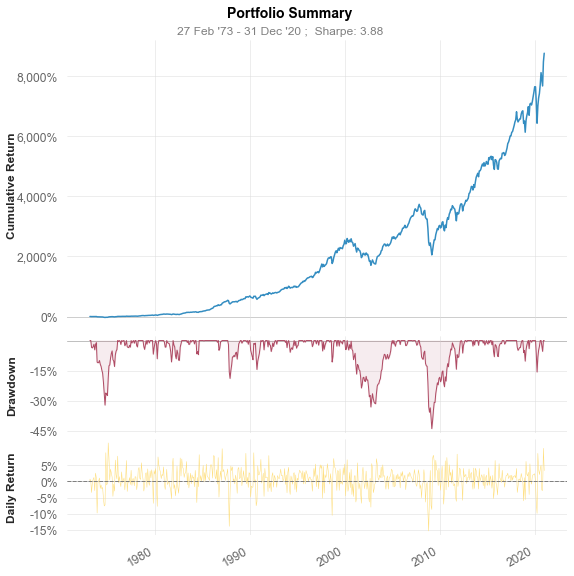

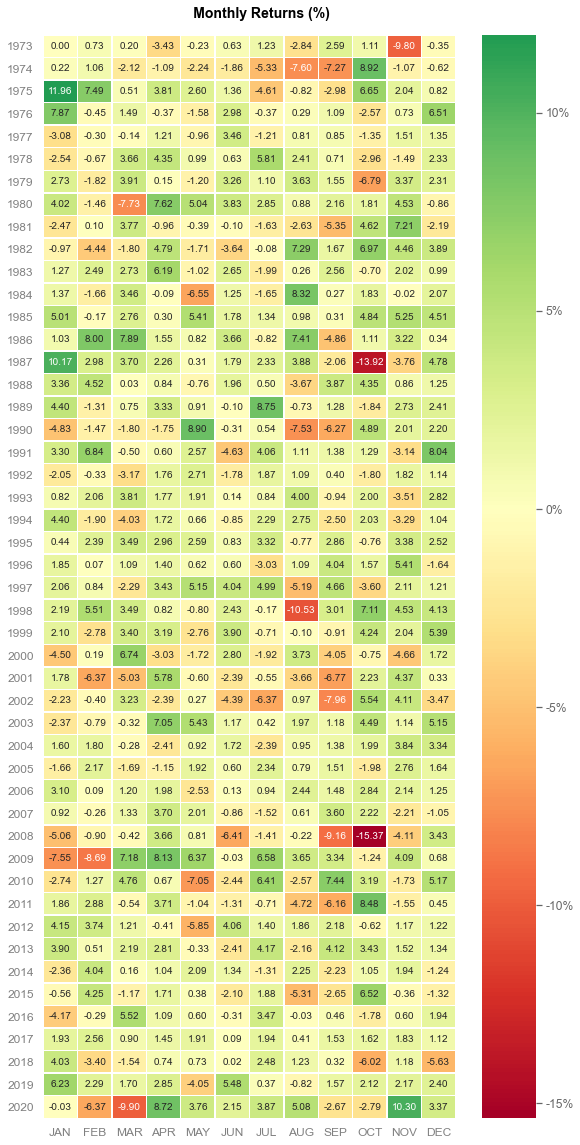

In [22]:
quantstats.reports.plots(Monthly_FourFund['Monthly_FourFund'], mode='basic')

연 복리 수익률 9.82%, 샤프 비율은 위에서 계산한대로 0.85, MDD는 -44%입니다. 대공황 시기가 아닌데도 40%대 MDD는 큽니다.

In [23]:
quantstats.reports.metrics(Monthly_FourFund['Monthly_FourFund'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               1973-02-28
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          8,757.91%
CAGR%                      9.82%
Sharpe                     3.88
Sortino                    6.14
Max Drawdown               -43.87%
Longest DD Days            1706
Volatility (ann.)          54.69%
Calmar                     0.22
Skew                       -0.5
Kurtosis                   1.79

Expected Daily %           0.78%
Expected Monthly %         0.78%
Expected Yearly %          9.79%
Kelly Criterion            30.61%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.82%
Expected Shortfall (cVaR)  -4.82%

Payoff Ratio               1.05
Profit Factor              1.9
Common Sense Ratio         2.37
CPC Index                  1.28
Tail Ratio                 1.25
Outlier Win Ratio          3.17
Outlier Loss Ratio        